In [295]:
"""
``autoreload`` is an IPython extension that reloads modules
automatically before executing the line of code typed.
"""

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [296]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [297]:
RAW_DATA_PATH = Path('__file__').absolute().parents[1] / 'data' / '01_raw'
PROCESSED_DATA_PATH = Path('__file__').absolute().parents[1] / 'data' / '02_processed'
RAW_DATA_PATH

WindowsPath('c:/Users/Lyndon/Documents/University/CS3AM/coursework/CS3AM-COURSEWORK/data/01_raw')

In [298]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = [15, 8]

In [299]:
sns.set_style('whitegrid')

In [300]:
def read_and_format_csv(subfolder_path: Path, raw_path: bool = True) -> pd.DataFrame:
    if raw_path:
        path = str(RAW_DATA_PATH / subfolder_path)
        df = pd.read_csv(path)
    else:
        path = str(PROCESSED_DATA_PATH / subfolder_path)
        df = pd.read_csv(path)
        
    
    df = df.astype({col: 'float32' for col in ['Open', 'High', 'Low', 'Close', 'Adj Close',]})
    df['stock_name'] = df['stock_name'].astype('str')
    df['Volume'] = df['Volume'].astype('int32')

    df['Date'] = pd.to_datetime(df['Date'], format='ISO8601', utc='True')
    df['Date'] = pd.to_datetime(df['Date'].dt.date)
    return df

In [301]:
df = read_and_format_csv(subfolder_path='Information_Technology/AAPL.csv', raw_path=True)
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name
0,1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600,AAPL
1,1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800,AAPL
2,1980-12-16,0.086802,0.112723,0.113281,0.112723,0.113281,105728000,AAPL
3,1980-12-17,0.088951,0.115513,0.116071,0.115513,0.115513,86441600,AAPL
4,1980-12-18,0.091530,0.118862,0.119420,0.118862,0.118862,73449600,AAPL


Make sure Dates are sorted

In [302]:
df.sort_values(by='Date', inplace=True)
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name
0,1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600,AAPL
1,1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800,AAPL
2,1980-12-16,0.086802,0.112723,0.113281,0.112723,0.113281,105728000,AAPL
3,1980-12-17,0.088951,0.115513,0.116071,0.115513,0.115513,86441600,AAPL
4,1980-12-18,0.091530,0.118862,0.119420,0.118862,0.118862,73449600,AAPL


In [303]:
df.dtypes

Date          datetime64[ns]
Adj Close            float32
Close                float32
High                 float32
Low                  float32
Open                 float32
Volume                 int32
stock_name            object
dtype: object

## Focusing on Daily resolution and returns

<Axes: xlabel='Date', ylabel='Close'>

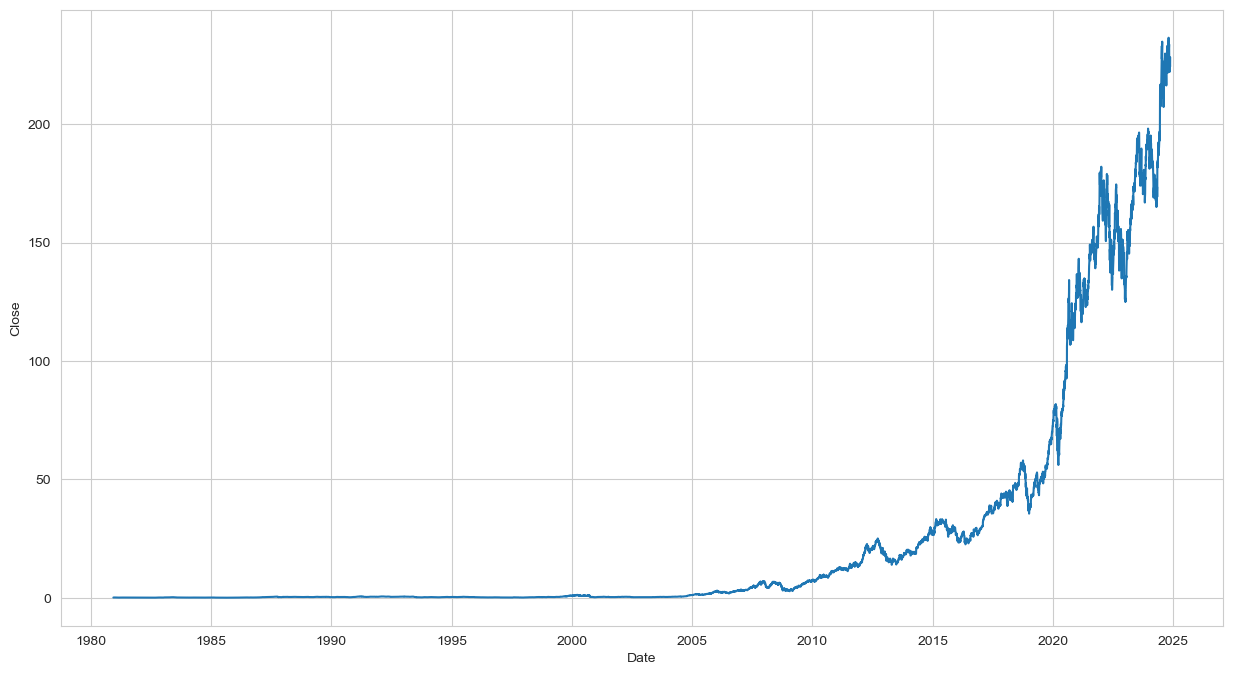

In [304]:
f, ax = plt.subplots(nrows=1, ncols=1,)

sns.lineplot(data=df, x='Date', y='Close', markers='o')

In [305]:
df['Returns'] = df['Adj Close'].pct_change()
df['first_diff'] = df['Adj Close'].diff()
df

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff
0,1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600,AAPL,NaN,NaN
1,1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800,AAPL,-0.052171,-0.005156
2,1980-12-16,0.086802,0.112723,0.113281,0.112723,0.113281,105728000,AAPL,-0.073397,-0.006876
3,1980-12-17,0.088951,0.115513,0.116071,0.115513,0.115513,86441600,AAPL,0.024751,0.002148
4,1980-12-18,0.091530,0.118862,0.119420,0.118862,0.118862,73449600,AAPL,0.028993,0.002579
...,...,...,...,...,...,...,...,...,...,...
11069,2024-11-08,226.960007,226.960007,228.660004,226.410004,227.169998,38328800,AAPL,-0.001188,-0.269989
11070,2024-11-11,224.229996,224.229996,225.699997,221.500000,225.000000,42005600,AAPL,-0.012029,-2.730011
11071,2024-11-12,224.229996,224.229996,225.589996,223.360001,224.550003,40398300,AAPL,0.000000,0.000000
11072,2024-11-13,225.119995,225.119995,226.649994,222.759995,224.009995,48566200,AAPL,0.003969,0.889999


Stock market contains less data points for 1980 so we start at 1981

In [306]:
df = df.loc[df['Date'].dt.year > pd.Timestamp('1980').year].reset_index(drop=True)
df.head(2)

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff
0,1981-01-02,0.118602,0.154018,0.155134,0.154018,0.154018,21660800,AAPL,0.010989,0.001289
1,1981-01-05,0.116024,0.150670,0.151228,0.150670,0.151228,35728000,AAPL,-0.021738,-0.002578


In [307]:
df.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,Date,Adj Close,Close,High,Low,Open,Volume,Returns,first_diff
count,11061,11061.000000,11061.000000,11061.000000,11061.000000,11061.000000,1.106100e+04,11061.000000,11061.000000
mean,2002-11-30 02:56:32.026037376,22.893742,23.732557,23.969788,23.473480,23.716425,3.025108e+08,0.001077,0.020622
min,1981-01-02 00:00:00,0.037815,0.049107,0.049665,0.049107,0.049665,-2.108338e+09,-0.518692,-10.566132
10%,1985-05-16 00:00:00,0.103992,0.134487,0.137277,0.132813,0.135045,6.835660e+07,-0.028096,-0.176617
25%,1991-12-09 00:00:00,0.243658,0.300781,0.306429,0.292411,0.300223,1.110652e+08,-0.012620,-0.008989
50%,2002-11-25 00:00:00,0.442485,0.540179,0.549107,0.531250,0.540179,2.030448e+08,0.000000,0.000000
75%,2013-11-19 00:00:00,17.913139,20.999643,21.236429,20.821428,21.079287,3.933552e+08,0.014385,0.014069
90%,2020-06-24 00:00:00,87.711876,90.014999,91.250000,88.254997,90.019997,7.011536e+08,0.030815,0.261644
99%,2024-06-08 04:48:00,197.054633,198.020004,198.887994,195.934000,197.151996,1.504470e+09,0.077555,3.431161
max,2024-11-14 00:00:00,236.220108,236.479996,237.490005,234.449997,236.479996,2.127171e+09,0.332281,13.998383


In [308]:
df.dropna(inplace=True)

<Axes: xlabel='Date', ylabel='Returns'>

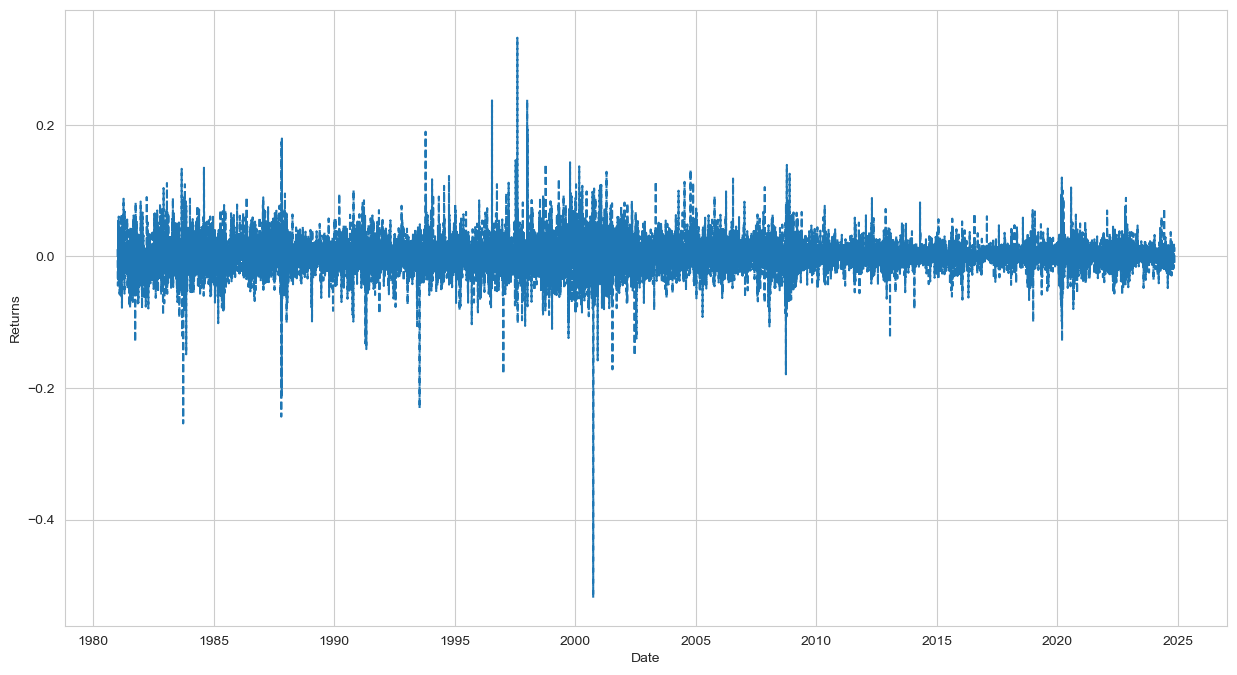

In [309]:
sns.lineplot(data=df, x='Date', y='Returns', linestyle='--', markers='o')

---

In [310]:
# df.columns

In [311]:
# df = df[['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
#        'Returns', 'first_diff']]

# df.head()

## Deep Modelling

In [312]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [313]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)


In [314]:
# from math import ceil

# import tensorflow as tf
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import MinMaxScaler
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, LSTM
# from sklearn.metrics import mean_squared_error

In [315]:
# tf.config.list_physical_devices('GPU')

In [316]:
# tf.test.is_gpu_available()

In [317]:
# shape = df_deep.shape[0]
# df_new=df_deep['Returns'].values.reshape(-1, 1)

# train = df_deep.iloc[:ceil(shape * 0.9)]
# valid = df_deep.iloc[ceil(shape * 0.9):]

In [318]:
# # scaler = MinMaxScaler(feature_range=(0, 1))
# # scaled_data = scaler.fit_transform(df_new)
# # x_train, y_train = [], []
# # for i in range(40,len(train)):
# #     x_train.append(scaled_data[i-40:i,0])
# #     y_train.append(scaled_data[i,0])
# # x_train, y_train = np.array(x_train), np.array(y_train)
# # x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# # model = Sequential()
# # model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
# # model.add(LSTM(units=50))
# # model.add(Dense(1))
# # model.compile(loss='mean_squared_error', optimizer='adam')
# # model.fit(x_train, y_train, epochs=15, batch_size=1, verbose=2)

# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(df_new)

# x_train, y_train = [], []
# for i in range(40, len(train)):
#     x_train.append(scaled_data[i-40:i, 0])
#     y_train.append(scaled_data[i, 0])
# x_train, y_train = np.array(x_train), np.array(y_train)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model.add(LSTM(units=50))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')

# model.fit(x_train, y_train, epochs=15, batch_size=1, verbose=2)

# scaled_test_data = scaler.transform(df_new)
# x_test, y_test = [], []
# for i in range(40, len(scaled_test_data)):
#     x_test.append(scaled_test_data[i-40:i, 0])
#     y_test.append(scaled_test_data[i, 0])
# x_test = np.array(x_test)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# # Predict and calculate MSE
# predictions = model.predict(x_test)
# mse = mean_squared_error(y_test, predictions)
# print(f'Mean Squared Error on Test Data: {mse}')


---

In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow.keras.metrics as metrics

import tensorflow as tf

In [320]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [321]:
df_deep = df[['Date', 'Adj Close']].set_index('Date')
df_deep.head()

,Adj Close
Date,
1981-01-02,0.118602
1981-01-05,0.116024
1981-01-06,0.110867
1981-01-07,0.106140
1981-01-08,0.103992


In [322]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_deep['Adj Close'] = scaler.fit_transform(df_deep[['Adj Close']])
df_deep.head()

,Adj Close
Date,
1981-01-02,0.000342
1981-01-05,0.000331
1981-01-06,0.000309
1981-01-07,0.000289
1981-01-08,0.000280


In [323]:
# Create sequences for LSTM
sequence_length = 10
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:(i + seq_length)]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Create sequences
X, y = create_sequences(df_deep['Adj Close'].values, sequence_length)

# Split into train and test (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [324]:
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, 
         input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])


model.compile(optimizer='adam', loss='mse', metrics=[metrics.AUC(), metrics.RootMeanSquaredError(), metrics.MeanAbsolutePercentageError(), metrics.MeanAbsoluteError()])

do i need to pass in returns or can i just pass in adj close

In [325]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
221/221 [==============================] - 7s 25ms/step - loss: 5.4197e-06 - auc_12: 0.5551 - root_mean_squared_error: 0.0023 - mean_absolute_percentage_error: 367.8194 - mean_absolute_error: 0.0013 - val_loss: 2.7131e-04 - val_auc_12: 0.0000e+00 - val_root_mean_squared_error: 0.0165 - val_mean_absolute_percentage_error: 18.3173 - val_mean_absolute_error: 0.0134
Epoch 2/50
221/221 [==============================] - 5s 24ms/step - loss: 1.2731e-06 - auc_12: 0.5617 - root_mean_squared_error: 0.0011 - mean_absolute_percentage_error: 317.8658 - mean_absolute_error: 7.0033e-04 - val_loss: 1.2538e-04 - val_auc_12: 0.0000e+00 - val_root_mean_squared_error: 0.0112 - val_mean_absolute_percentage_error: 16.4724 - val_mean_absolute_error: 0.0099
Epoch 3/50
221/221 [==============================] - 5s 25ms/step - loss: 1.6017e-06 - auc_12: 0.5604 - root_mean_squared_error: 0.0013 - mean_absolute_percentage_error: 156.9804 - mean_absolute_error: 7.9075e-04 - val_loss: 8.3589e-05 - val_a

70/70 [==============================] - 0s 7ms/step


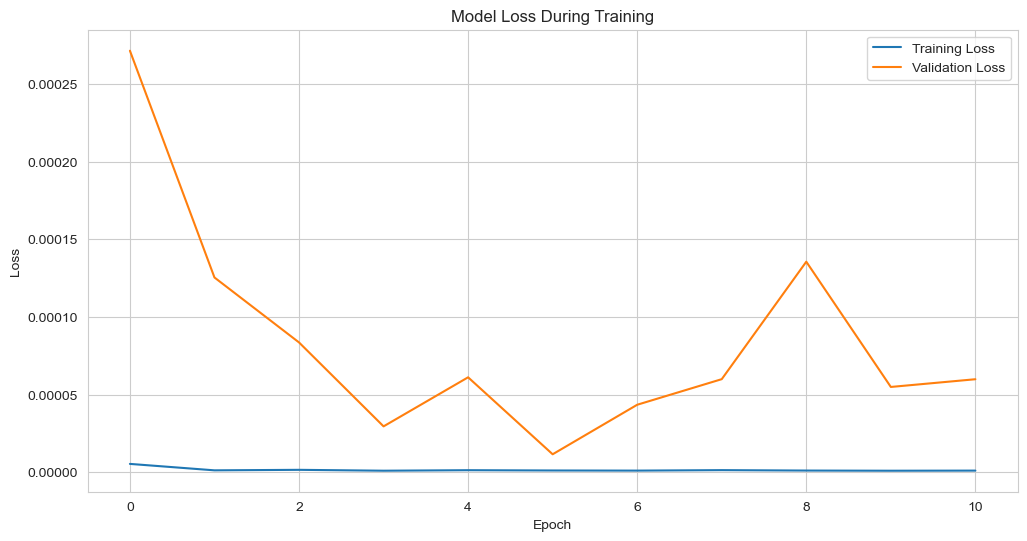

0.039009217 0.356313


In [326]:
# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Calculate metrics
train_rmse = np.sqrt(np.mean((y_train - train_pred) ** 2))
test_rmse = np.sqrt(np.mean((y_test - test_pred) ** 2))

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(train_rmse, test_rmse)

70/70 [==============================] - 1s 8ms/step


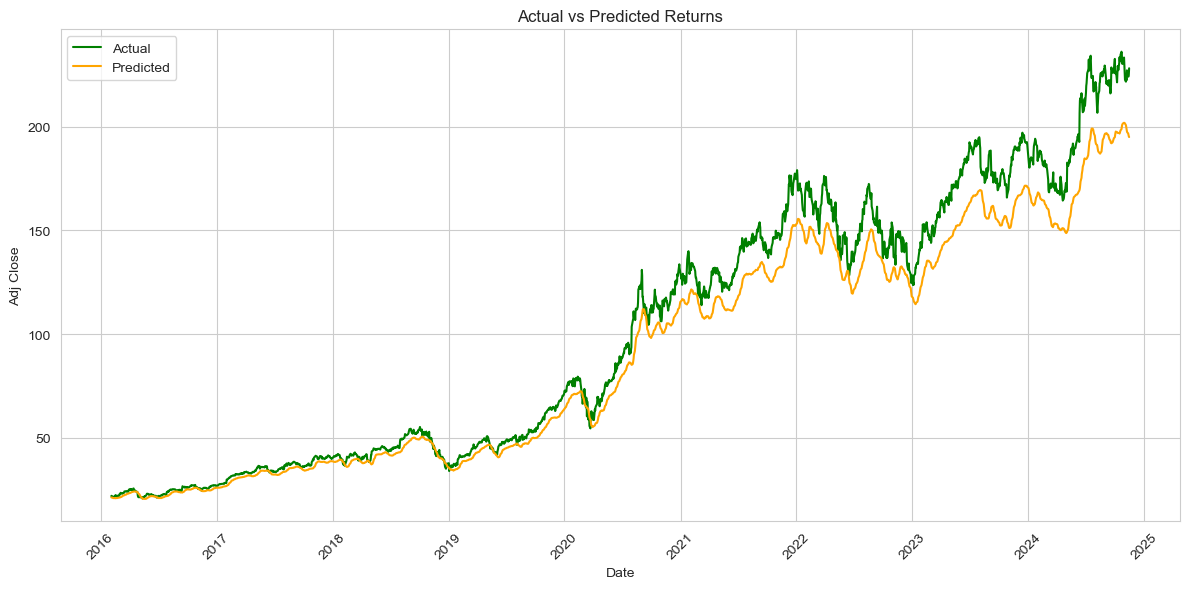

In [327]:
# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 2: Inverse transform the predictions and actual values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Step 3: Create a DataFrame with the original dates, actual values, and predicted values
forecast_dates = df_deep.index[train_size + sequence_length:]
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Actual': y_test_inv.flatten(),
    'Predicted': y_pred_inv.flatten()
})

# Step 4: Plot the results
plt.figure(figsize=(12, 6))
# plt.plot(df['Date'], df['Adj Close'], label='full_timeseries', color='blue')
plt.plot(forecast_df['Date'], forecast_df['Actual'], label='Actual', color='green')
plt.plot(forecast_df['Date'], forecast_df['Predicted'], label='Predicted', color='orange')
plt.title('Actual vs Predicted Returns')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


70/70 [==============================] - 1s 8ms/step


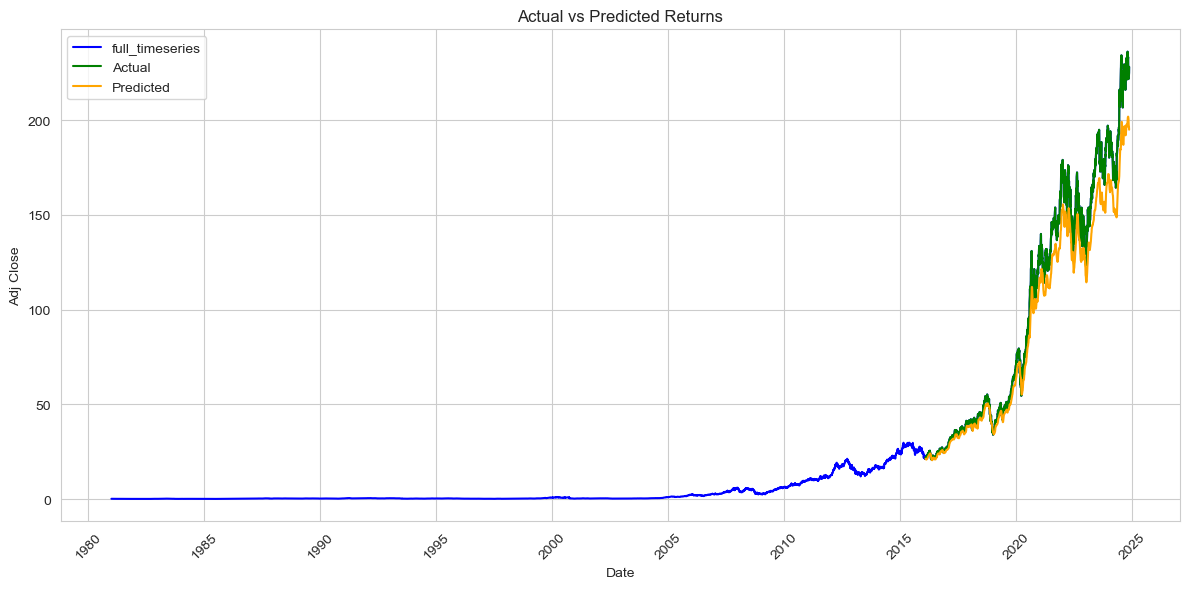

In [328]:
# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 2: Inverse transform the predictions and actual values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Step 3: Create a DataFrame with the original dates, actual values, and predicted values
forecast_dates = df_deep.index[train_size + sequence_length:]
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Actual': y_test_inv.flatten(),
    'Predicted': y_pred_inv.flatten()
})

# Step 4: Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Adj Close'], label='full_timeseries', color='blue')
plt.plot(forecast_df['Date'], forecast_df['Actual'], label='Actual', color='green')
plt.plot(forecast_df['Date'], forecast_df['Predicted'], label='Predicted', color='orange')
plt.title('Actual vs Predicted Returns')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [329]:
history.history.keys()

dict_keys(['loss', 'auc_12', 'root_mean_squared_error', 'mean_absolute_percentage_error', 'mean_absolute_error', 'val_loss', 'val_auc_12', 'val_root_mean_squared_error', 'val_mean_absolute_percentage_error', 'val_mean_absolute_error'])

In [330]:
model.evaluate(X_test, y_test)

70/70 [==============================] - 1s 10ms/step - loss: 0.0035 - auc_12: 0.0000e+00 - root_mean_squared_error: 0.0595 - mean_absolute_percentage_error: 8.6815 - mean_absolute_error: 0.0444


[0.0035441548097878695,
 0.0,
 0.05953280255198479,
 8.6815185546875,
 0.04437066242098808]

In [331]:
forecast_df

,Date,Actual,Predicted
0,2016-02-04,21.997526,21.201248
1,2016-02-05,21.410013,21.189365
2,2016-02-08,21.635454,21.060558
3,2016-02-09,21.630905,20.974798
4,2016-02-10,21.466942,20.880978
...,...,...,...
2206,2024-11-08,226.960007,197.339401
2207,2024-11-11,224.229996,196.812531
2208,2024-11-12,224.229996,196.106995
2209,2024-11-13,225.119995,195.418442


In [332]:
# model.save('../models/LSTM_best.h5')